# COMP 598 Final Project: COVID in Canada

Want to know:
- The salient topics discussed around COVID and what each topic primarily concerns
- Relative engagement with those topics
- How positive/negative the response to the pandemic/vaccination has been

Characterize your topics by computing the 10 words in each category with the highest 1f-idf scores.  To compute inverse document frequency, use all 1000 posts that you originally collected.

Run as follows:

    python3 analysis.py -i <tweets.csv> -o <analysis.json>

Note:
- 'annotation' column is the topic

In [1]:
import argparse
import json
import math
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import  TweetTokenizer
from nltk.tokenize import  word_tokenize
from collections import OrderedDict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [2]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('-i', '--input_file', required=True)
    parser.add_argument('-o', '--output_file', required=False)
    parser.add_argument('-s', '--stopwords_file', required=False)
    args = parser.parse_args()
    
    return args.input_file, args.output_file, args.stopwords_file

def clean_data(df):
    # drop columns with missing data
    df = df.dropna()
    
    # drop columns with unintelligible meaning
    df = df.loc[df['annotation'] != 'U']
    
    # drop columns marked 'discard'
    df = df.loc[df['annotation'] != 'D']
    
    # lowercase annotations and sentiments
    df['annotation'] = df['annotation'].str.lower()
    df['sentiment'] = df['sentiment'].str.lower()
    
    # p: politics, s: school, a: opinions, w: workplace, e: personal, c: info
    to_replace = {'p': 'politics', 's': 'school', 'a': 'opinions', 'w': 'workplace', 'e': 'personal', 'c': 'info', 'c ': 'info'}
    df['annotation'] = df['annotation'].replace(to_replace)
    
    # replace sentiment values with 'positive', 'negative', and 'neutral'
    to_replace = {'+': 'positive', '-': 'negative', '0': 'neutral', 'p': 'positive', 'pos': 'positive'}
    df['sentiment'] = df['sentiment'].replace(to_replace)
    
    return df

# get words that occur at least 2 times across ALL tweets
def get_words(df, stopwords_file=None, frequency=2):
    # list of stopwords
    if stopwords_file != None:
        with open(stopwords_file) as f:
            stopwords = f.read().splitlines()
    
    all_words = {}
    
    tweet_list = df['tokenized_tweet'].to_list()
    
    # filter to include: hashtag, isalpha(), not stopword
    for tweet in tweet_list:
        for word in tweet:
            if (((word[0] == '#') and (len(word) > 1)) or ((word.isalpha()) and (word not in stopwords))):
                # hashtags counted as normal word
                if word[0] == '#':
                    word = word[1:]
                
                if word in all_words:
                    all_words[word] += 1
                else:
                    all_words[word] = 1
                    
    word_list = []
    
    # frequency above threshold
    for word in all_words:
        if all_words[word] >= frequency:
            word_list.append(word)
            
    return word_list

# output dictionary has all words in word_list
# some word counts could be 0
def get_word_counts(df, word_list, annotation):
    word_counts = {word:0 for word in word_list}
    total = 0
    
    df_annotation = df.loc[df['annotation'] == annotation]
    tweet_list = df_annotation['tokenized_tweet'].to_list()
    
    for tweet in tweet_list:
        for word in tweet:
            if word in word_counts:
                word_counts[word] += 1
                total += 1
    
    return word_counts, total

# get tf-idf values for each word for each annotation
def get_tfidfs(all_word_counts, totals):
    annotations = list(all_word_counts.keys())
    
    all_tfidfs = {}
    
    for annotation in all_word_counts:
        all_tfidfs[annotation] = {}
    
        for word in all_word_counts[annotation]:
            # get tf
            # tf(t, d) = (# of times t occurs in d) / (total # of words in d)
            tf = all_word_counts[annotation][word] / totals[annotation]
            
            if tf <= 0:
                tfidf = 0
                
            else:
                # get idf
                # idf(t) = log((total # of documents) / (# of d where t appears))
                num_annotations = len(all_word_counts)
                num_a_use_w = 0
                
                for a in annotations:
                    if all_word_counts[a][word] > 0:
                        num_a_use_w += 1
            
                tfidf = tf * math.log(num_annotations / num_a_use_w)

            all_tfidfs[annotation][word] = tfidf
            
    return all_tfidfs

def get_top_n_tfidfs(all_tfidfs, num_words=10, get_sorted=False):
    sorted_tfidfs = {}
    
    for annotation in all_tfidfs:
        x = all_tfidfs[annotation]
        sorted_tfidfs[annotation] = dict(sorted(x.items(), key=lambda item: item[1], reverse=True))
    
    top_n = {}
    
    for annotation in sorted_tfidfs:
        sorted_keys = list(sorted_tfidfs[annotation].keys())
        top_n[annotation] = sorted_keys[:num_words]
    
    if get_sorted:
        return top_n, sorted_tfidfs
    
    else:
        return top_n

def get_sentiment(df, annotation):
    df_annotation = df.loc[df['annotation'] == annotation]

    positive = df_annotation.loc[df_annotation['sentiment'] == 'positive']
    negative = df_annotation.loc[df_annotation['sentiment'] == 'negative']
    neutral = df_annotation.loc[df_annotation['sentiment'] == 'neutral']
    
    sentiment = {}
    sentiment['negative'] = negative.shape[0]
    sentiment['neutral'] = neutral.shape[0]
    sentiment['positive'] = positive.shape[0]
    
    return sentiment

def dict_to_matrix(all_tfidfs):
    # rows are annotations, columns are words
    annotations = list(all_tfidfs.keys())
    matrix = np.zeros((len(all_tfidfs),len(all_tfidfs[annotations[0]])))
    
    i = 0
    for annotation in all_tfidfs:
        j = 0
        for word in all_tfidfs[annotation]:
            matrix[i][j] = all_tfidfs[annotation][word]
            j += 1
            
        i += 1
        
    return matrix

# plot number of tweets in each category
def plot_tweets_by_cat(df, ylim=50, dpi=100):
    tweets_by_cat = df['annotation'].value_counts().to_dict()
    od = OrderedDict(sorted(tweets_by_cat.items()))
    
    max_y = max(list(od.values()))

    plt.figure(dpi=dpi)
    plt.bar(x=od.keys(), height=od.values())
    plt.xlabel('topics')
    plt.ylabel('number of tweets')
    plt.ylim(0,max_y+ylim)

    count = 0
    for topic in od:    
        height = od[topic]
        label_x_pos = count
        plt.text(x=label_x_pos, y=height, s=f'{height}', ha='center', va='bottom')
        count += 1

    plt.show()
    
    return od

# plot number of positive, negative, and neutral tweets
def plot_sentiment(df, ylim=50, dpi=100):
    tweets_by_sent = df['sentiment'].value_counts().to_dict()
    od = OrderedDict(sorted(tweets_by_sent.items()))
    
    max_y = max(list(od.values()))

    plt.figure(dpi=dpi)
    plt.bar(x=od.keys(), height=od.values())
    plt.xlabel('sentiment')
    plt.ylabel('number of tweets')
    plt.ylim(0,max_y+ylim)

    count = 0
    for topic in od:    
        height = od[topic]
        label_x_pos = count
        plt.text(x=label_x_pos, y=height, s=f'{height}', ha='center', va='bottom')
        count += 1

    plt.show()
    
    return od

# plot number of positive, negative, and neutral tweets in each category
def plot_sent_by_cat(all_sentiment, ylim=50, dpi=100):
    od = OrderedDict(sorted(all_sentiment.items()))
    labels = list(od.keys())
    x = np.arange(1,len(labels)+1)

    negative = [od[y]['negative'] for y in od]
    neutral = [od[y]['neutral'] for y in od]
    positive = [od[y]['positive'] for y in od]

    fig, ax = plt.subplots(dpi=dpi)
    width = 0.25
    
    all_y = negative + neutral + positive
    max_y = max(all_y)

    rects1 = ax.bar(x=x-width, height=negative, width=width, label='negative')
    rects2 = ax.bar(x=x, height=neutral, width=width, label='neutral')
    rects3 = ax.bar(x=x+width, height=positive, width=width, label='positive')

    ax.set_ylabel('number of tweets')
    ax.set_xlabel('topics')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(top=max_y+ylim)
    ax.legend()

    rects = [rects1, rects2, rects3]
    for rect in rects:
        for bar in rect:    
            height = bar.get_height()
            label_x_pos = bar.get_x() + bar.get_width() / 2
            ax.text(label_x_pos, height, s=f'{height}', ha='center', va='bottom')

    fig.tight_layout()

    plt.show()
    
    return od

def get_vax_word_counts(df_vax, word_list):
    word_counts = {word:0 for word in word_list}
    total = 0

    tweet_list = df_vax['tokenized_tweet'].to_list()

    for tweet in tweet_list:
        for word in tweet:
            if word in word_counts:
                word_counts[word] += 1
                total += 1
                
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
    return sorted_word_counts, total


In [3]:
remove_words = ['vaccineswork', 'largestvaccinedrive', 'covidvaccine', 'bigpharma', 'covid19vaccine', 'getvaccinated', 'epub', 'don', 've', 'am', 'vis', 're', 'ain', 'pts', 'haven', 'cdnpoli', 'im', 'ny', 'cr', 'doesn', 'qld', 'aren', 'bout', 'didn', 'isn', 'st', 'parisikastenbadboys', 'nxtwargames', 'till', 'dont', 'de', 'ツ', 'كؤد', 'omicronindia', 'sams', 'ida', 'vhcon', 'usafacts', 'datavisualization', 'datascience', 'publichealth', 'globalhealth', 'uhurulegacysecured', 'ms', 'latestnews', 'moneycontrol', 'pi', 'boinc', 'esp', 'amrefcovid19response', 'ie', 'kzn', 'cvs', 'gp', 'pm', 'san', 'yr', 'ommcomnews', 'ist', 'ey', 'economictimes', 'nh', 'rt', 'vs', 'mpol385', 'natujengetaifaletu', 'nj', 'pmevidya', 'breakingnews', 'hasn', 'uts', 'yan', 'fr', 'pr', 'meri', 'ㅤ', 'tp', 'wouldn', 'cc', 'lb', 'isnt', 'ap', 'sa', 'howrah', 'auspol', 'behandeling', 'en', 'mtn', '702breakfast', 'rs', 'mps', 'philippine', 'msm', 'zerohedge', 'vaers']


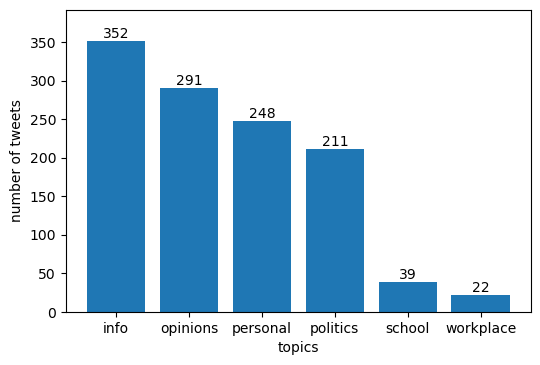

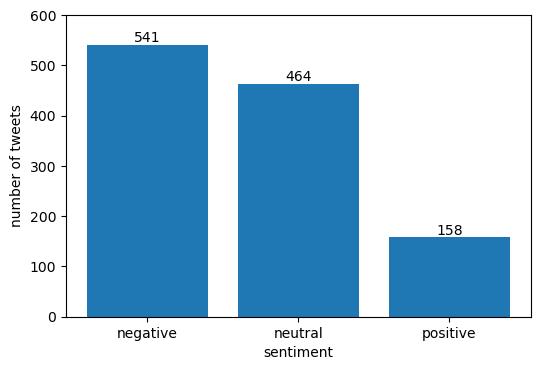

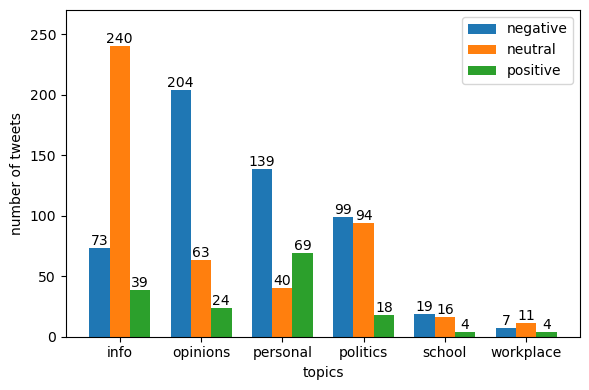

In [4]:
# input_file, output_file, stopwords_file = get_args()
input_file = 'tweets.csv'
stopwords_file = 'stopwords.txt'

df = pd.read_csv(input_file)
num_tweets = df.shape[0]

# -------------------- CLEAN DATA -----------------------

df = clean_data(df)
pd.options.display.max_colwidth = 1000

# remove 2 French tweets
df = df.drop([987, 988])

# -------------------- TOKENIZE -------------------------

# add tokenized_tweet column with tokenized tweets
df['tokenized_tweet'] = df['tweet'].str.lower()

# tokenize with TweetTokenizer() from nltk
tt = TweetTokenizer()
df['tokenized_tweet'] = df['tokenized_tweet'].apply(tt.tokenize)

# manually tokenize
# lowercase words, replace punctuation with spaces, split by spaces
# df['tokenized_tweet'] = df['tweet'].str.lower()
# punc_to_space = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
# df['tokenized_tweet'] = df['tokenized_tweet'].str.translate(punc_to_space)
# df['tokenized_tweet'] = df['tokenized_tweet'].str.split()

# -------------------- TF-IDF ---------------------------

word_list = get_words(df, stopwords_file=stopwords_file, frequency=2)

# manually remove words
word_list = [word for word in word_list if word not in remove_words]

annotations = df['annotation'].unique()

# word counts for each annotation
all_word_counts = {}

# total words in document (each "document" is all the tweets for one annotation)
totals = {}

for annotation in annotations:
    all_word_counts[annotation], totals[annotation] = get_word_counts(df, word_list, annotation)

all_tfidfs = get_tfidfs(all_word_counts, totals)

top_n = get_top_n_tfidfs(all_tfidfs, num_words=10, get_sorted=False)
# top_n, sorted_tfidfs = get_top_n_tfidfs(all_tfidfs, num_words=10, get_sorted=True)

# -------------------- SENTIMENT ------------------------

all_sentiment = {}

for annotation in annotations:
    all_sentiment[annotation] = get_sentiment(df, annotation)

# -------------------- VISUALIZATION --------------------

# number of tweets in each category
tweets_by_cat = plot_tweets_by_cat(df, ylim=40)

# number of positive, negative, and neutral tweets
tweets_by_sent = plot_sentiment(df, ylim=60)

# number of positive, negative, and neutral tweets in each category
sent_by_cat = plot_sent_by_cat(all_sentiment, ylim=30)

# tf-idf value of top 3 words in each category
# top_3, sorted_tfidfs = get_top_n_tfidfs(all_tfidfs, num_words=3, get_sorted=True)
# top_3_w_values = {}
# for annotation in top_3:
    # top_3_w_values[annotation] = {}
    # for word in top_3[annotation]:
        # value = sorted_tfidfs[annotation][word]
        # top_3_w_values[annotation][word] = value
        
# -------------------- SKLEARN --------------------------

# corpus = df['tweet'].to_numpy()
# vectorizer = CountVectorizer(vocabulary=word_list)
# X = vectorizer.fit_transform(corpus)
# features = vectorizer.get_feature_names()

# lda = LatentDirichletAllocation(n_components=8, random_state=42)
# lda.fit(X)
# doc_topic_distr = lda.transform(X)

# https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
# topic_words = {}
# n_top_words = 10

# for topic, comp in enumerate(lda.components_):
    # word_idx = np.argsort(comp)[::-1][:n_top_words]
    # topic_words[topic] = [features[i] for i in word_idx]

# for topic, words in topic_words.items():
    # print('Topic: %d' % topic)
    # print('  %s' % ', '.join(words))


In [5]:
# -------------------- OUTPUT ---------------------------

print('total number of tweets:', num_tweets)
print('number of cleaned and annotated tweets:', df.shape[0])
print()

# top_n, all_sentiment
print('top_n:')
print(json.dumps(OrderedDict(sorted(top_n.items())), indent=2))
print()

print('all_sentiment:')
print(json.dumps(OrderedDict(sorted(all_sentiment.items())), indent=2))
print()


total number of tweets: 1210
number of cleaned and annotated tweets: 1163

top_n:
{
  "info": [
    "reports",
    "uk",
    "insights",
    "analytics",
    "pericarditis",
    "omicron",
    "rise",
    "infection",
    "player",
    "ben"
  ],
  "opinions": [
    "govts",
    "abuse",
    "people",
    "costly",
    "advisors",
    "twitter",
    "killed",
    "naturally",
    "world",
    "flu"
  ],
  "personal": [
    "kody",
    "little",
    "lol",
    "mom",
    "smell",
    "hotel",
    "booster",
    "fever",
    "bed",
    "trash"
  ],
  "politics": [
    "blasio",
    "mayor",
    "sector",
    "mandate",
    "employers",
    "queensland",
    "city",
    "reopen",
    "trump",
    "nyc"
  ],
  "school": [
    "school",
    "students",
    "schools",
    "exams",
    "class",
    "institutions",
    "return",
    "dressed",
    "quality",
    "diseases"
  ],
  "workplace": [
    "aviation",
    "profitable",
    "omg",
    "investors",
    "customers",
    "blessed",
    "c

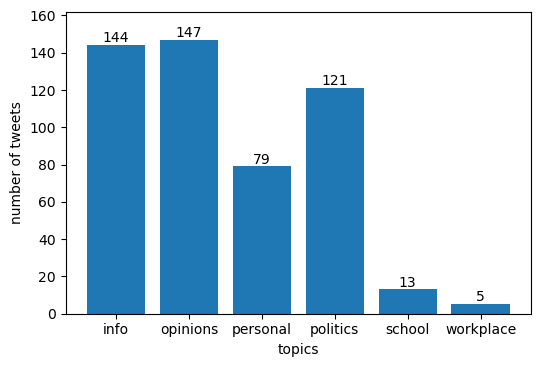

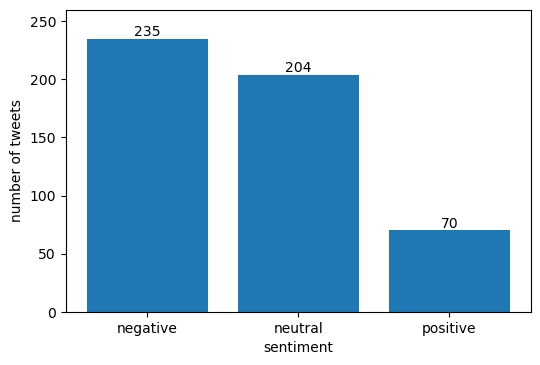

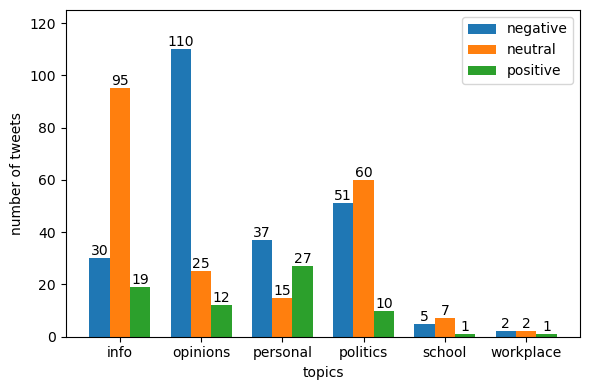

In [6]:
# -------------------- VACCINATION ----------------------

# join tokens
df['joined_tweet'] = df['tokenized_tweet'].str.join(',')

# vaccine-related words
vaccine_related = ['vaccination', 'vaxed', 'vaccine', 'pfizer', 'vaccines', 'shots', 'jab', 'vaccinated', 'vax', 'anti', 'boosters', 'unvaxxed', 'passports', 'shot', 'moderna', 'vaxxed', 'unvaccinated', 'mrna', 'antivaxxers', 'johnson', 'dose', 'vaccinations', 'inoculation', 'boosted', 'jabs', 'vaxx']
vaccine_regex = 'vaccination|vaxed|vaccine|pfizer|vaccines|shots|jab|vaccinated|vax|anti|boosters|unvaxxed|passports|shot|moderna|vaxxed|unvaccinated|mrna|antivaxxers|johnson|dose|vaccinations|inoculation|boosted|jabs|vaxx'

# understand discussions surrounding vaccine hesitancy
df_vax = df[df['joined_tweet'].str.contains(pat=vaccine_regex)]

# word frequency
vax_word_freq, vax_total = get_vax_word_counts(df_vax, word_list)

# annotation
vax_by_cat = plot_tweets_by_cat(df_vax, ylim=15)

# sentiment
vax_by_sent = plot_sentiment(df_vax, ylim=25)

# annotation and sentiment
vax_sentiment = {}
vax_annotations = df_vax['annotation'].unique()

for annotation in vax_annotations:
    vax_sentiment[annotation] = get_sentiment(df_vax, annotation)

vax_sent_by_cat = plot_sent_by_cat(vax_sentiment, ylim=15)

# -------------------- TF-IDF ---------------------------

# word_list, annotations variable

# word counts for each annotation
vax_all_word_counts = {}

# total words in document (each "document" is all the tweets for one annotation)
vax_totals = {}

for annotation in annotations:
    vax_all_word_counts[annotation], vax_totals[annotation] = get_word_counts(df_vax, word_list, annotation)

vax_all_tfidfs = get_tfidfs(vax_all_word_counts, vax_totals)

vax_top_n = get_top_n_tfidfs(vax_all_tfidfs, num_words=10, get_sorted=False)

# -------------------- SKLEARN --------------------------

# corpus = df_vax['tweet'].to_numpy()

# vectorizer = CountVectorizer(vocabulary=word_list)
# X = vectorizer.fit_transform(corpus)
# features = vectorizer.get_feature_names()

# vectorizer = TfidfVectorizer(vocabulary=word_list)
# X = vectorizer.fit_transform(corpus)
# features = vectorizer.get_feature_names()

# https://stackoverflow.com/questions/34232190/scikit-learn-tfidfvectorizer-how-to-get-top-n-terms-with-highest-tf-idf-score
# feature_array = np.array(features)
# tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]

# n = 20
# vax_top_n = feature_array[tfidf_sorting][:n]


In [7]:
# -------------------- OUTPUT ---------------------------

print('number of vaccine-related tweets:', df_vax.shape[0])
print()

print('top 20 words by frequency:', list(vax_word_freq.keys())[:20])
print()

# vax_top_n
print('vax_top_n:')
print(json.dumps(OrderedDict(sorted(vax_top_n.items())), indent=2))
print()

# print('vax_top_n:')
# print(vax_top_n)
# print()

print('vax_sentiment:')
print(json.dumps(OrderedDict(sorted(vax_sentiment.items())), indent=2))
print()


number of vaccine-related tweets: 509

top 20 words by frequency: ['vaccine', 'covid', 'vaccination', 'vaccinated', 'people', 'vaccines', 'mandate', 'pfizer', 'booster', 'shot', 'getting', 'omicron', 'health', 'via', 'mandates', 'private', 'doses', 'virus', 'nyc', 'taking']

vax_top_n:
{
  "info": [
    "pericarditis",
    "player",
    "ben",
    "madgen",
    "diagnosed",
    "former",
    "antiviral",
    "oral",
    "dr",
    "omicron"
  ],
  "opinions": [
    "naturally",
    "costly",
    "advisors",
    "govts",
    "abuse",
    "vax",
    "mandates",
    "dr",
    "please",
    "divisive"
  ],
  "personal": [
    "card",
    "tomorrow",
    "bed",
    "booster",
    "found",
    "literally",
    "newsom",
    "heard",
    "yesterday",
    "morning"
  ],
  "politics": [
    "blasio",
    "mayor",
    "nyc",
    "city",
    "sector",
    "announced",
    "mandate",
    "queensland",
    "private",
    "york"
  ],
  "school": [
    "students",
    "school",
    "send",
    "diseas